In [1]:
import matplotlib.pyplot as plt
from pathlib import Path

import gammapy
import numpy as np
import astropy
import regions
import scipy

print("gammapy:", gammapy.__version__)
print("numpy:", np.__version__)
print("astropy", astropy.__version__)
print("regions", regions.__version__)
print("scipy", scipy.__version__)


from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
from astropy.coordinates import SkyCoord, Angle

from regions import CircleSkyRegion

from gammapy.data import DataStore, GTI, Observation, EventList
from gammapy.datasets import (FluxPointsDataset, MapDataset, MapDatasetEventSampler, 
                              Datasets, SpectrumDataset, SpectrumDatasetOnOff)
from gammapy.maps import MapAxis, WcsGeom, Map
from gammapy.irf import load_irf_dict_from_file
from gammapy.makers import SafeMaskMaker, SpectrumDatasetMaker, ReflectedRegionsBackgroundMaker, MapDatasetMaker
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Model,
    Models,
    SkyModel,
    PowerLawSpectralModel,
    PowerLawNormSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    TemplateSpatialModel,
    TemplateSpectralModel,
    FoVBackgroundModel,
)


import copy
import scipy.stats as stats

from gammapy.estimators import (
    FluxPoints, 
    FluxPointsEstimator, 
    TSMapEstimator
)

from regions import CircleSkyRegion

gammapy: 1.3
numpy: 2.1.3
astropy 6.1.6
regions 0.10
scipy 1.14.1


In [2]:
BASE_PATH=Path(".")

In [3]:
dataset = MapDataset.read('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/dataset_NGC1068_50hr.fits')

In [4]:
center = SkyCoord.from_name("NGC 1068").icrs

offset = 0.5 * u.deg

pointing_position = center.directional_offset_by(position_angle=0 * u.deg, separation=offset)

ENERGY_AXIS = MapAxis.from_energy_bounds(
    "0.1 TeV", "100.0 TeV", nbin=10, per_decade=True       #IRF range
)
    

WCS_GEOM = WcsGeom.create(
    skydir=pointing_position,
    width=(10, 10),         #REMEMBER: if you want to point off-axis 4°, you need a wider field     
    binsz=0.02,          #binsize simulation << PSF 
    frame="icrs",
    axes=[ENERGY_AXIS],
)

e_min, e_max, e_bins = 0.1, 100.0, 10
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), e_bins) * u.TeV

dataset_original = Models.read("/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/Experiment/Wind_NGC_1068.yaml") 

In [30]:
# spectral_model = PowerLawSpectralModel(
#     amplitude = 5.76e-14  * u.Unit("cm-2 s-1 TeV-1"),
#     index = 2.3,
#     reference = 1 * u.TeV,
# )

spectral_model = ExpCutoffPowerLawSpectralModel(
   amplitude = 8.04e-13 * u.Unit("cm-2 s-1 TeV-1"),
   index = 1.96,
   lambda_ = 2.626  * u.Unit("TeV-1"),
   reference = 1 * u.TeV,
   alpha = 3.95
)

# Source
point_model = PointSpatialModel(
    lon_0="40.669 deg", 
    lat_0="-0.013 deg", 
    frame='icrs'
)

MainSourceAn = "NGC1068_Wind"   

# Background
bkg_model = FoVBackgroundModel(dataset_name="my-dataset")

sky_model = SkyModel(
                    spectral_model=spectral_model,
                    spatial_model=point_model,
 #                   temporal_model=expdecay_model,
                    name=MainSourceAn,
                    )

# Define the whole model
models = Models([sky_model, bkg_model])


models[0].spatial_model.parameters['lon_0'].frozen=True       #Spatial coordinate freezed
models[0].spatial_model.parameters['lat_0'].frozen=True

W VariableMetricBuilder No improvement in line search
W VariableMetricBuilder Reached machine accuracy limit; Edm 0.00242733 is smaller than machine limit 0.405492 while 0.0002 was requested
W VariableMetricBuilder No convergence; Edm 0.00242733 is above tolerance 0.002


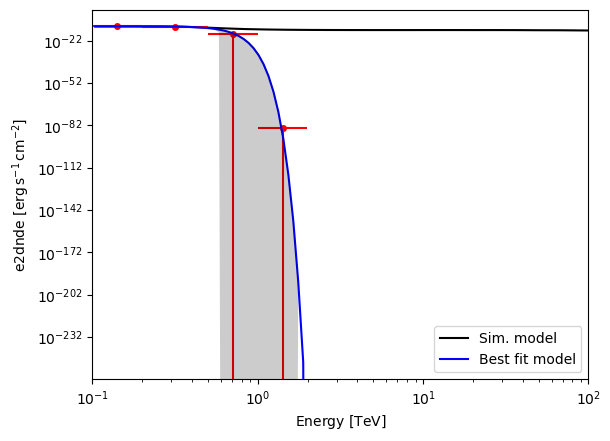

In [ ]:
dataset.models = models


# spectral_model.index.frozen = True

# #spectral_model.amplitude.frozen = True

# #spectral_model.lambda_.frozen = True

# spectral_model.alpha.frozen = True

events = EventList.read('/Users/tharacaba/Desktop/Tesis_2/MASS_Thesis/simulations/Wind/100sims/events/NGC1068_50hr_events_0.fits')
counts = Map.from_geom(WCS_GEOM)
counts.fill_events(events)
dataset.counts = counts

fit = Fit(optimize_opts={"print_level": 1})
result = fit.run([dataset])

fpe = FluxPointsEstimator(energy_edges=e_edges, source=MainSourceAn)
flux_points = fpe.run(datasets=dataset)
flux_points.is_ul = flux_points.ts < 9

ax = dataset_original[0].spectral_model.plot(
energy_bounds=(0.1, 400) * u.TeV, 
label="Sim. model",
sed_type="e2dnde",
color='black'
)

px = {"color": "red", "marker":"o"}
mx = {"color": "blue"}

flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset.models[0])
flux_points_dataset.plot_spectrum(ax=ax, kwargs_fp=px, kwargs_model=mx)
ax.legend()

In [32]:
print(dataset.models[0])

SkyModel

  Name                      : NGC1068_Wind
  Datasets names            : None
  Spectral model type       : ExpCutoffPowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                 (frozen):      1.960                   
    amplitude                     :   8.03e-13   +/- 6.4e-14 1 / (TeV s cm2)
    reference             (frozen):      1.000       TeV         
    lambda_                       :      2.620   +/-    0.13 1 / TeV     
    alpha                 (frozen):      3.950                   
    lon_0                 (frozen):     40.669       deg         
    lat_0                 (frozen):     -0.013       deg         


